# Определение возраста покупателей

## Исследовательский анализ данных

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

- Контролировать добросовестность кассиров при продаже алкоголя.

Построим модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

### Начнем новый проект - сначала проведем небольшой анализ данных:
Импортируем библиотеки

Загрузим данные

Посмотрим как устроен датасет

Сделаем info(), и построим график по реальному возрасту

In [2]:
import pandas as pd
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Посмотрим на наш файл

In [4]:
display(labels)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [5]:
display(labels.head(10))

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


Посмотрим как часто встречается тот или иной возраст и посмотрим график соотношения

In [6]:
labels['real_age'].value_counts()

30     317
25     315
27     229
26     226
28     217
      ... 
96       2
93       1
100      1
91       1
97       1
Name: real_age, Length: 97, dtype: int64

Text(0.5, 1.0, 'Распределение по возрасту')

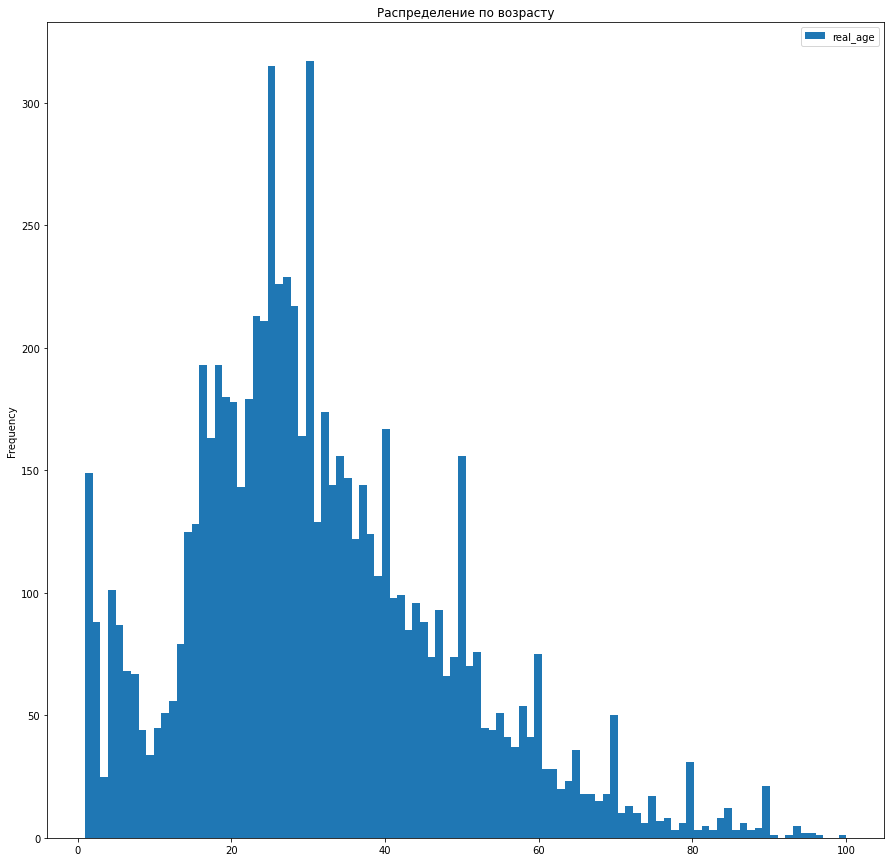

In [7]:
labels['real_age'].plot(kind='hist', figsize=(15,15), bins=100).legend()
plt.title('Распределение по возрасту')

<AxesSubplot:>

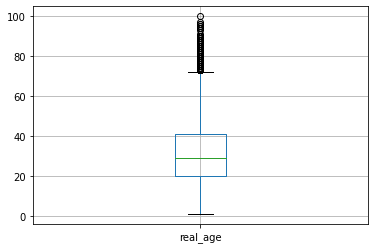

In [8]:
labels.boxplot()

Основная масса людей возрастом от 20 до 40, выбросы от 70 лет примерно. В целом все укладывается в общую картину - чего-то странного тут не вижу

In [9]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [10]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Посмотрим размер выборки

In [11]:
labels.shape

(7591, 2)

Напечатаем 15 изображений и посмотрим с какими данными нам работать

In [12]:
features, target = next(train_gen_flow)

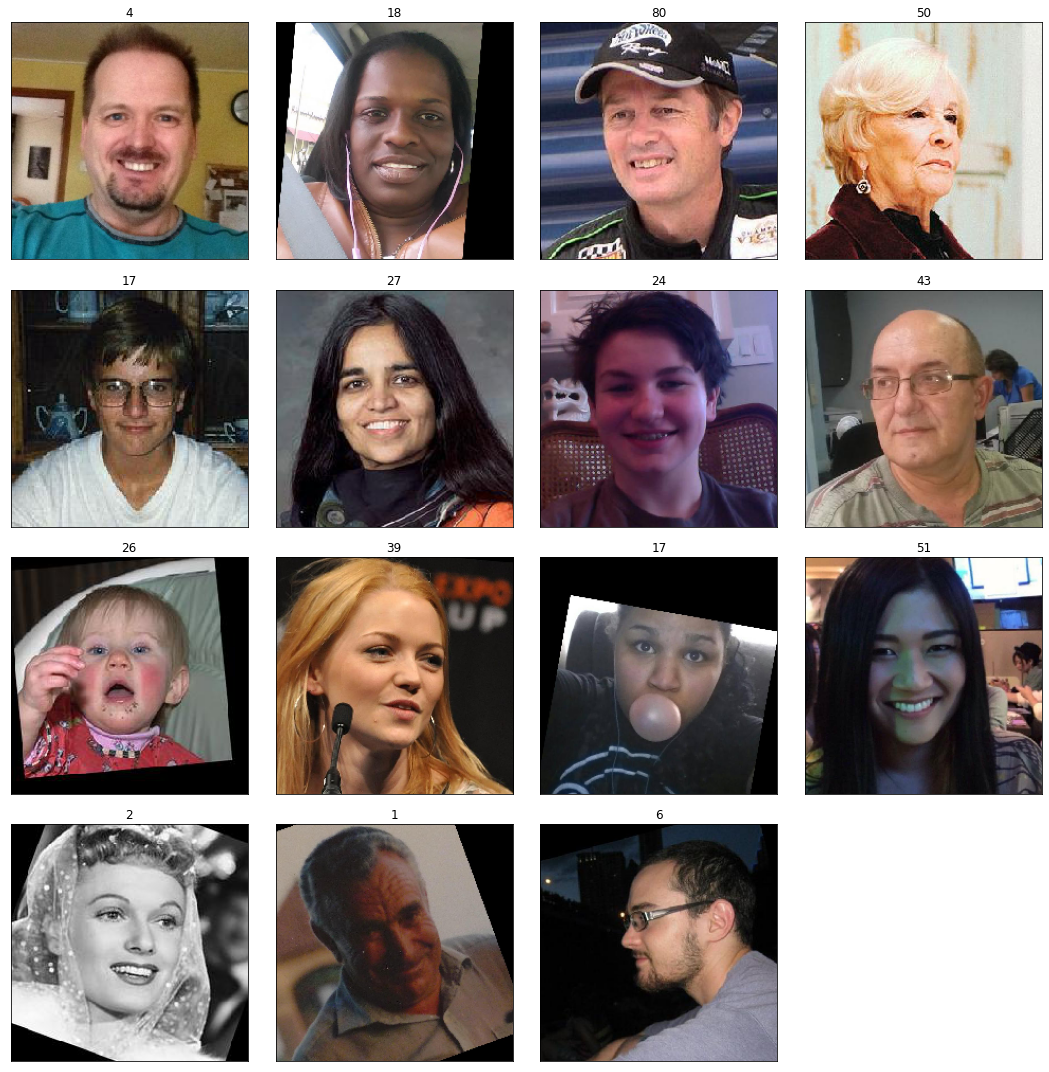

In [13]:
fig = plt.figure(figsize=(15,15))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(labels['real_age'][i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

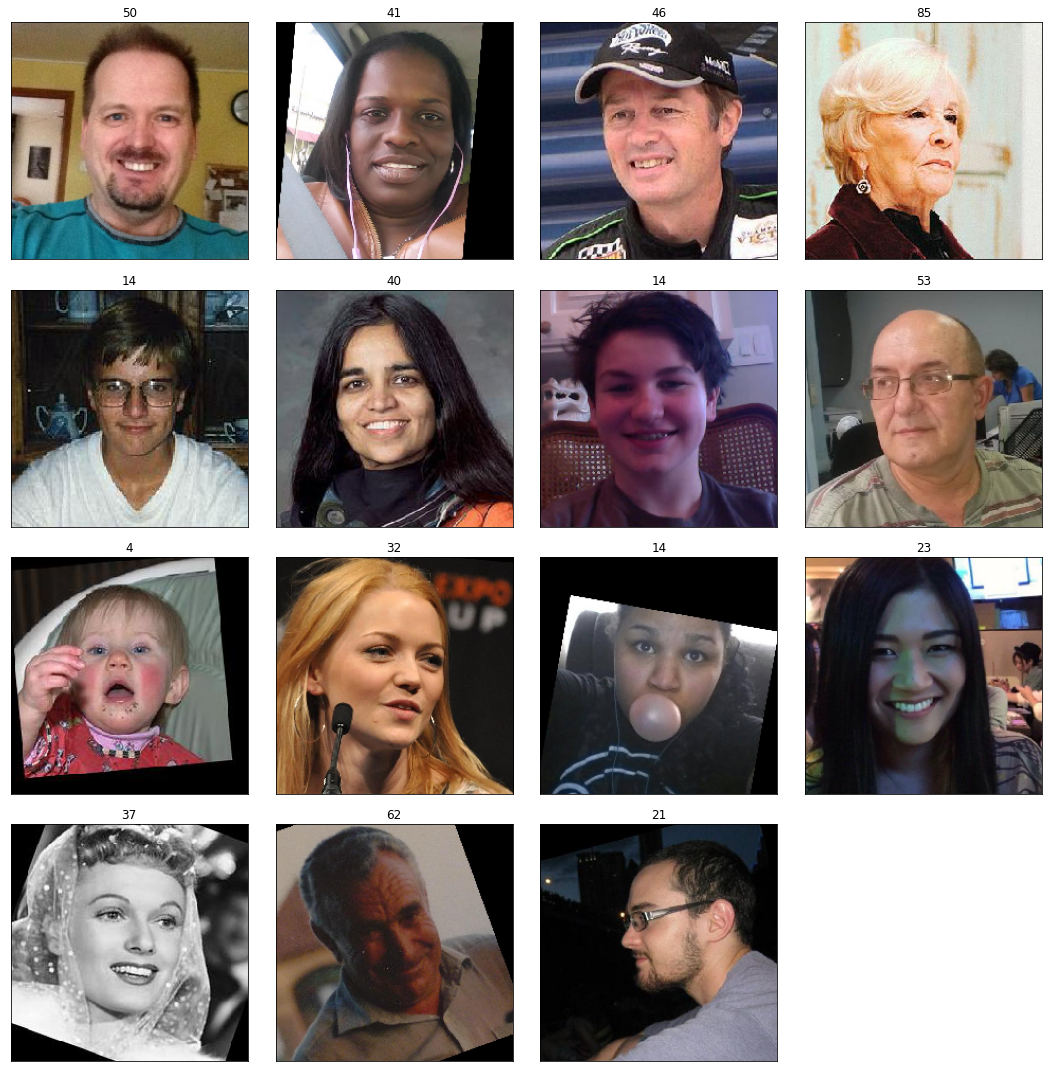

In [14]:
fig = plt.figure(figsize=(15,15))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Сделаем небольшой вывод:

- Загрузили данные

- Итого у нас 7591 фотография и столбец с таргетом (реальным возрастом людей). Пропусков нет, задача регрессии - нужно вычислить возраст людей по картинке

- При просмотре гистограммы есть 2 пика (примерно 25 и 30 лет). Это может быть связано с тем, что развитие и уменьшение техники для съемок, начиная с 1990 годов, привели к тому что самые активные люди 20-30 лет и любят делать фото. Более старшему поколению не так нравятся все новинки в технике. Более молодым, подросткам, детям не позволяет финансовое положение делать много селфи из-за отсутсвия личного фотоаппарата/телефона.

- При просмотре примеров фотографий можно найти как страые образцы (середина прошлого века), так и самые новые с недавнего прошлого

- Будем использовать нейросети. Возможно ResNet - она позволяет добиться отличного качества модели

- Данных для обучения (7591 фотографий людей) хватает.

## Обучение модели

```python

Код модели для проекта

from tensorflow.keras.layers import Dense, Conv2D, AvgPool2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd



def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow
def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                       weights='imagenet',
                       include_top=False)
    
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=8,
               steps_per_epoch=None, validation_steps=None):
    #train_datagen_flow = train_data
    #test_datagen_flow = test_data
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model 

```

```
Результат работы модели

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/8
356/356 - 68s - loss: 198.5661 - mae: 10.2800 - val_loss: 651.7810 - val_mae: 20.5718
Epoch 2/8
356/356 - 37s - loss: 70.7190 - mae: 6.3569 - val_loss: 191.0026 - val_mae: 10.6002
Epoch 3/8
356/356 - 38s - loss: 39.5112 - mae: 4.8632 - val_loss: 130.5094 - val_mae: 8.6795
Epoch 4/8
356/356 - 38s - loss: 26.2640 - mae: 3.9547 - val_loss: 70.0808 - val_mae: 6.2653
Epoch 5/8
356/356 - 37s - loss: 18.6852 - mae: 3.3387 - val_loss: 86.9551 - val_mae: 6.9362
Epoch 6/8
356/356 - 37s - loss: 13.6760 - mae: 2.8253 - val_loss: 77.4786 - val_mae: 6.5953
Epoch 7/8
356/356 - 38s - loss: 12.5313 - mae: 2.6983 - val_loss: 73.1709 - val_mae: 6.2742
Epoch 8/8
356/356 - 38s - loss: 10.9927 - mae: 2.5398 - val_loss: 76.1753 - val_mae: 6.4756

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 76.1753 - mae: 6.4756
Test MAE: 6.4756

```

## Анализ обученной модели

Анализ модели и выводы по ее работе:

- Для модели использовали нейросеть ResNet50

- Предварительно загрузили картинки и разбили наш датасет на тестовую выборку и валидационную(тестовую)

- Выбрали метрику MAE - среднее сумму разницы между прогнозом модели и фактическим значением

- Следуя полученному значению MAE (6.4756) - среднее абсолютное откленение равно ~ 6,5 годам. В целом модель смело можно использовать для первой нашей задачи (анализировать покупки определенной возрастной группы и предлагать для данной группы сопутсвующие товары). Для второй задачи (проверка кассиров при покупке алкоголя/сигарет) метрика MAE может быть не так эффективна. Среднее отклонение 6,5 лет - кассиры спрашивают паспорт и не продают алкоголь/сигареты до 18 лет. Пограничный возраст для вопроса про паспорт для покупателя при покупке алкоголя составляет 25-28 лет примерно. Модель может использоваться и для второй задачи, но результат пограничный.

- По нашим задачам с метрикой MAE сможем сделать 

- Использовали алгоритм Адам с шагом в lr=0.0001

- Количество эпох ограничили 8, epochs=8

- В качестве ключевой метрики выбрали MAE

- Результатом данной модели стала MAE = 6.4756, что ниже требуемых 8. Задача выполнена

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы